#### Core & Data Libraries

In [2]:
# ============================== Core & Data Libraries ==============================
import os                                   # File and directory operations
import pickle                               # Object serialization
import numpy as np                          # Numerical computations
import pandas as pd                         # Data manipulation and analysis

# ============================== Visualization Libraries ============================
import matplotlib.pyplot as plt              # Static plots and figures
from matplotlib.ticker import MultipleLocator # Axis tick control
from matplotlib.lines import Line2D          # Custom legend elements
import seaborn as sns                       # Statistical data visualization

# ============================== Machine Learning & Stats ===========================
from sklearn.mixture import GaussianMixture                   # Gaussian mixture models
from sklearn.metrics import mean_squared_error, r2_score      # Model evaluation metrics

from scipy.optimize import curve_fit                # Curve fitting, optimization
from scipy.stats import kstest, norm, t, skewnorm, cauchy     # Specific probability distributions
from scipy.interpolate import interp1d                        # 1D interpolation

import statsmodels.api as sm                                  # Advanced statistical modeling
import statsmodels.formula.api as smf                         # Formula-based regression

#### Load OOF Residuals

In [4]:
# pick your residuals CSV (alias shown; change if needed)
RESID_PATH = "../Extended Parametric Regression Files+Plots/Reports/Residuals_OOF/residuals__POLY2__BEST__oof.csv"

df_res = pd.read_csv(RESID_PATH)
res_col = next(c for c in ["resid_db", "residuals", "resid", "error"] if c in df_res.columns)
residuals = df_res[res_col].astype(float)  # kept as Series so `.values` works later
n = residuals.size
probabilities = (np.arange(1, n + 1) - 0.5) / n  # Standard probability calculation

#### Fit Distributions

In [6]:
# === Fit Distributions ===

# 1. Normal Distribution
normal_params = norm.fit(residuals)
loc_norm, scale_norm = normal_params
normal_dist = norm(loc=loc_norm, scale=scale_norm)

# 2. Skew-Normal Distribution
skew_params = skewnorm.fit(residuals)
shape_sn, loc_sn, scale_sn = skew_params
skew_dist = skewnorm(shape_sn, loc=loc_sn, scale=scale_sn)

# 3. Gaussian Mixture Model (Automated Model Selection 1 and 2)
residuals_array = residuals.values.reshape(-1, 1)
lowest_bic = np.inf
bic_scores = []
# up to 5 components
n_components_range = range(1, 6)
best_gmm = None

for n_components in n_components_range:
    gmm_tmp = GaussianMixture(n_components=n_components, random_state=42).fit(residuals_array)
    bic_value = gmm_tmp.bic(residuals_array)
    bic_scores.append(bic_value)
    if bic_value < lowest_bic:
        lowest_bic = bic_value
        best_gmm = gmm_tmp

gmm = best_gmm  # Use the best GMM selected based on the lowest BIC
print(f"\nSelected GMM with {gmm.n_components} components based on lowest BIC: {lowest_bic}")

# 4. Cauchy Distribution
cauchy_params = cauchy.fit(residuals)
cauchy_dist = cauchy(*cauchy_params)

# 5. t-Distribution
t_params = t.fit(residuals)
df_t, loc_t, scale_t = t_params
t_dist = t(df=df_t, loc=loc_t, scale=scale_t)

# === Compute Log-Likelihood, AIC, BIC, and KS Test ===
def compute_aic_bic(log_likelihood, num_params, num_samples):
    """Compute AIC and BIC values."""
    aic = 2 * num_params - 2 * log_likelihood
    bic = num_params * np.log(num_samples) - 2 * log_likelihood
    return aic, bic

# Normal Distribution
loglik_norm = np.sum(np.log(normal_dist.pdf(residuals)))
aic_norm, bic_norm = compute_aic_bic(loglik_norm, 2, n)  # 2 params: loc, scale
ks_norm = kstest(residuals, normal_dist.cdf)

# Skew-Normal Distribution
loglik_sn = np.sum(np.log(skew_dist.pdf(residuals)))
aic_sn, bic_sn = compute_aic_bic(loglik_sn, 3, n)  # 3 params: shape, loc, scale
ks_sn = kstest(residuals, skew_dist.cdf)

# Robust GMM CDF helper (handles different covariance shapes)
def gmm_cdf(x, gmm_model):
    x = np.asarray(x)
    means = gmm_model.means_.ravel()
    covs = gmm_model.covariances_
    if covs.ndim == 3:
        covs = covs[:, 0, 0]
    elif covs.ndim == 2:
        covs = covs[:, 0]
    stds = np.sqrt(covs)
    weights = gmm_model.weights_.ravel()
    cdf = np.zeros_like(x, dtype=float)
    for w, m, s in zip(weights, means, stds):
        cdf += w * norm.cdf(x, loc=m, scale=s)
    return cdf

# Gaussian Mixture Model
# score() returns average log-likelihood; multiply by n for total
loglik_gmm = gmm.score(residuals_array) * n
# Parameter count for univariate GMM: (k-1) weights + k means + k variances = 3k - 1
aic_gmm, bic_gmm = compute_aic_bic(loglik_gmm, 3 * gmm.n_components - 1, n)
ks_gmm = kstest(residuals, lambda x: gmm_cdf(x, gmm))

# Cauchy Distribution
loglik_cauchy = np.sum(np.log(cauchy_dist.pdf(residuals)))
aic_cauchy, bic_cauchy = compute_aic_bic(loglik_cauchy, 2, n)  # 2 params: loc, scale
ks_cauchy = kstest(residuals, cauchy_dist.cdf)

# t-Distribution
loglik_t = np.sum(np.log(t_dist.pdf(residuals)))
aic_t, bic_t = compute_aic_bic(loglik_t, 3, n)  # 3 params: df, loc, scale
ks_t = kstest(residuals, t_dist.cdf)

# === Compile Diagnostics into a DataFrame ===
diagnostics = pd.DataFrame({
    'Distribution': ['Normal', 'Skew-Normal', 'Gaussian Mixture Model', 'Cauchy', 't-Distribution'],
    'Log-Likelihood': [loglik_norm, loglik_sn, loglik_gmm, loglik_cauchy, loglik_t],
    'AIC': [aic_norm, aic_sn, aic_gmm, aic_cauchy, aic_t],
    'BIC': [bic_norm, bic_sn, bic_gmm, bic_cauchy, bic_t],
    'KS Test Statistic': [ks_norm.statistic, ks_sn.statistic, ks_gmm.statistic, ks_cauchy.statistic, ks_t.statistic],
    'KS Test p-value': [ks_norm.pvalue, ks_sn.pvalue, ks_gmm.pvalue, ks_cauchy.pvalue, ks_t.pvalue]
})

diagnostics['Log-Likelihood'] = diagnostics['Log-Likelihood'].round(2)
diagnostics['AIC'] = diagnostics['AIC'].round(2)
diagnostics['BIC'] = diagnostics['BIC'].round(2)
diagnostics['KS Test Statistic'] = diagnostics['KS Test Statistic'].round(4)
diagnostics['KS Test p-value'] = diagnostics['KS Test p-value'].round(4)

print("\nDiagnostics Table:")
display(diagnostics)

best_fit = diagnostics.loc[diagnostics['KS Test Statistic'].idxmin()]
print(f"\nBest Fit (Based on KS Test Statistic): {best_fit['Distribution']}\n")


Selected GMM with 3 components based on lowest BIC: 8773980.464891162

Diagnostics Table:


,Distribution,Log-Likelihood,AIC,BIC,KS Test Statistic,KS Test p-value
0,Normal,-4530551.87,9061107.73,9061131.95,0.0700,0.0
1,Skew-Normal,-4499638.38,8999282.75,8999319.08,0.0587,0.0
2,Gaussian Mixture Model,-4386933.80,8773883.59,8773980.46,0.0101,0.0
3,Cauchy,-4546699.17,9093402.33,9093426.55,0.0778,0.0
4,t-Distribution,-4403757.05,8807520.10,8807556.43,0.0270,0.0



Best Fit (Based on KS Test Statistic): Gaussian Mixture Model



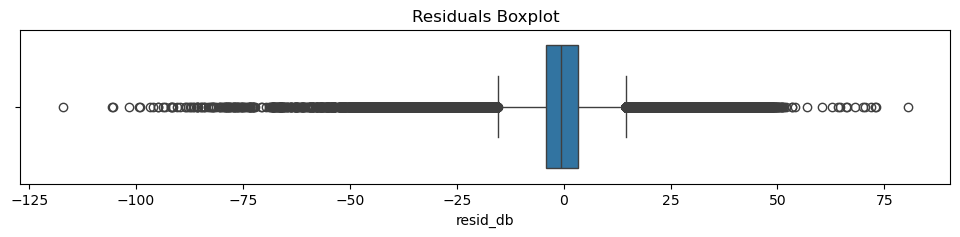

In [7]:
# === Inspect Residuals for Outliers ===
plt.figure(figsize=(12, 2))
sns.boxplot(x=residuals)
plt.title('Residuals Boxplot')
plt.show()

#### GMM Diagnostics (1–5 components)

In [9]:
# Convert residuals to a 2D array for GMM (required shape: [n_samples, n_features])
residuals_array = residuals.values.reshape(-1, 1)
gmm_models = []  # Define and initialize the list

# Initialize a list to store diagnostics for each GMM with different numbers of components
gmm_diagnostics = []

# Loop over the number of components (1 through 5)
for k in range(1, 6):
    # Fit GMM with k components using a fixed random state for reproducibility
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)
    
    # Calculate the total log-likelihood from the per-sample log probabilities.
    # Note: score_samples returns the log probability for each sample.
    loglik_k = np.sum(gmm_k.score_samples(residuals_array))
    
    # Estimate the number of free parameters for a mixture of Gaussians.
    # For each component: 1 weight (but total weights sum to 1: hence, k - 1 free parameters),
    # 1 mean, and 1 variance. Total parameters: (k - 1) + k + k = 3k - 1.
    num_params = 3 * k - 1
    
    # Compute AIC and BIC using standard formulas:    
    aic_k = 2 * num_params - 2 * loglik_k
    bic_k = num_params * np.log(len(residuals_array)) - 2 * loglik_k
    
    # Perform a Kolmogorov–Smirnov (KS) test on the residuals versus the GMM cumulative distribution.
    # We use our custom gmm_cdf function defined earlier.
    ks_result = kstest(residuals, lambda x: gmm_cdf(x, gmm_k))
    
    # Append the diagnostics for the current model to our list
    gmm_diagnostics.append({
        'GMM Components': k,
        'Log-Likelihood': loglik_k,
        'AIC': aic_k,
        'BIC': bic_k,
        'KS Statistic': ks_result.statistic,
        'KS p-value': ks_result.pvalue
    })

# Convert the collected diagnostics to a DataFrame
gmm_diag_df = pd.DataFrame(gmm_diagnostics)

print("\n=== GMM Diagnostics (Modes 1-5) ===\n")
display(gmm_diag_df)

# Select the best GMM based on the minimum AIC value (or BIC)
best_gmm_row = gmm_diag_df.loc[gmm_diag_df['BIC'].idxmin()]
best_gmm_components = best_gmm_row['GMM Components']
best_gmm = gmm_models[int(best_gmm_components) - 1]
print(f"\nBest GMM Model based on lowest BIC: {int(best_gmm_components)} components\n")


=== GMM Diagnostics (Modes 1-5) ===



,GMM Components,Log-Likelihood,AIC,BIC,KS Statistic,KS p-value
0,1,-4.530552e+06,9.061108e+06,9.061132e+06,0.070010,0.000000e+00
1,2,-4.396489e+06,8.792987e+06,8.793048e+06,0.011182,4.105126e-146
2,3,-4.386934e+06,8.773884e+06,8.773980e+06,0.010056,3.017375e-118
3,4,-4.387138e+06,8.774297e+06,8.774431e+06,0.014718,8.058363e-253
4,5,-4.391610e+06,8.783248e+06,8.783418e+06,0.009127,1.740497e-97



Best GMM Model based on lowest BIC: 3 components



#### Q–Q Plots for GMMs + Histogram Overlay

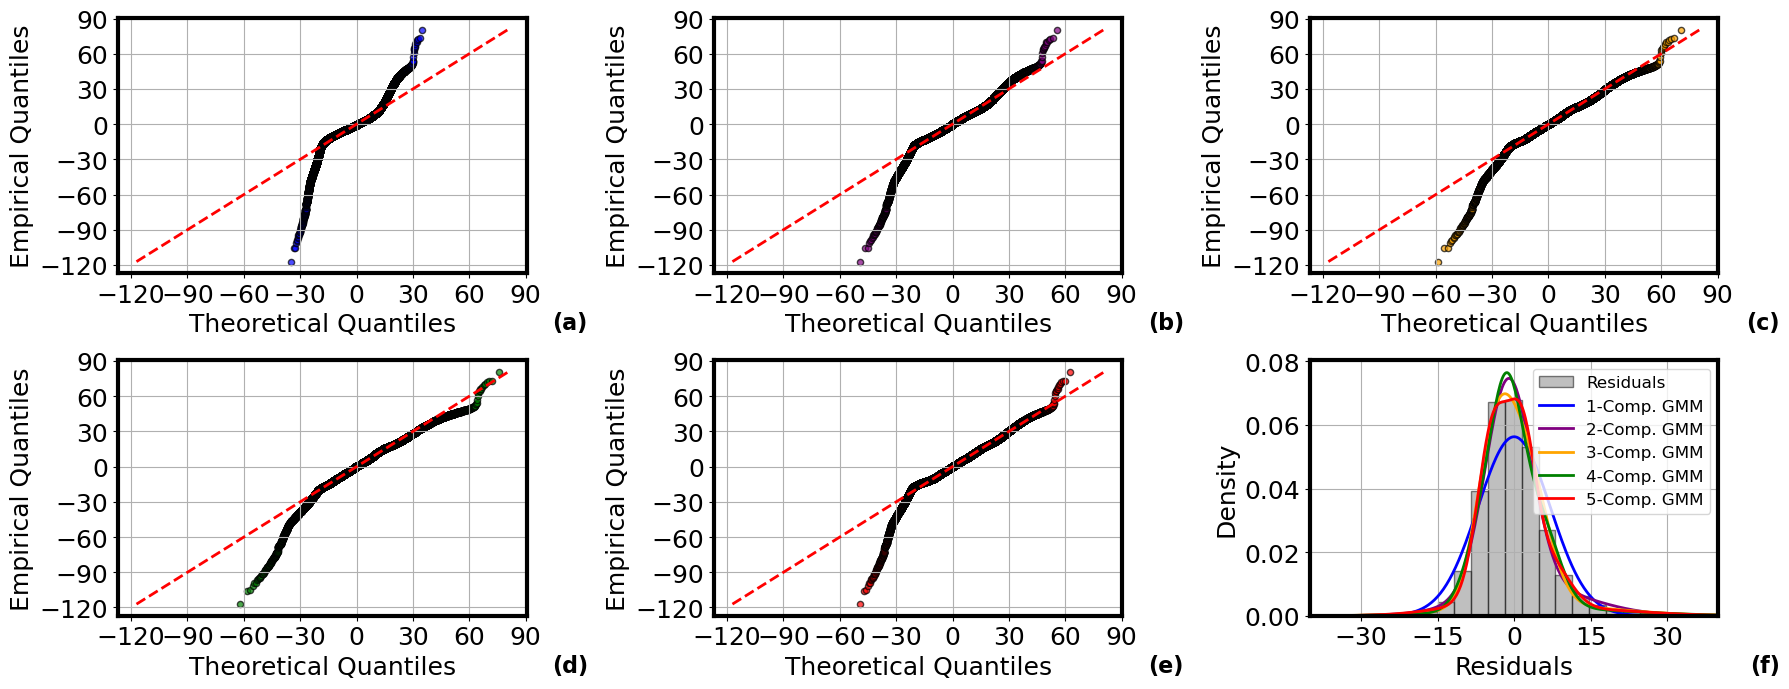

In [11]:
# --- Re-fit GMM models for 1 to 5 components and store them in a list ---
gmm_models = []
for k in range(1, 6):
    gmm_k = GaussianMixture(n_components=k, random_state=42).fit(residuals_array)
    gmm_models.append(gmm_k)

# Prepare sorted residuals and the corresponding probability positions
sorted_residuals = np.sort(residuals)
n = len(sorted_residuals)
probs = (np.arange(1, n + 1) - 0.5) / n  # Probability positions for quantiles

# --- Create a 2x3 grid for Q–Q plots and the combined histogram ---
fig, axes = plt.subplots(2, 3, figsize=(18, 7))
axes = axes.flatten()
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
gmm_colors = ['blue', 'purple', 'orange', 'green', 'red']

# --- Plot Q–Q plots for each of the 5 GMM models ---
for i, gmm_model in enumerate(gmm_models):
    ax = axes[i]
    
    # Generate a dense grid to compute the GMM CDF
    x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
    cdf_grid = gmm_cdf(x_grid, gmm_model)
    
    # Remove duplicate CDF values for reliable interpolation
    unique_cdf, unique_idx = np.unique(cdf_grid, return_index=True)
    unique_x = x_grid[unique_idx]
    # Create an interpolation function (PPF) from CDF to quantiles
    ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
    theoretical_quantiles = ppf_func(probs)
    
    # Scatter the theoretical versus empirical quantiles
    ax.scatter(theoretical_quantiles, sorted_residuals, color=gmm_colors[i], alpha=0.7, edgecolors='k', s=20)
    # Plot a 45° reference line
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
    
    ax.set_xlabel('Theoretical Quantiles', fontsize=18)
    ax.set_ylabel('Empirical Quantiles', fontsize=18)
    #ax.set_title(f'GMM with {i+1} Component(s)', fontsize=20)
    ax.text(1.15, -0.15, subplot_labels[i], transform=ax.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)
    ax.grid(True)

# --- Plot the 6th subplot: Histogram of residuals with overlaid GMM densities ---
ax6 = axes[5]
ax6.hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
for i, gmm_model in enumerate(gmm_models):
    # Compute the density for the current GMM (exponentiate the log probabilities)
    density = np.exp(gmm_model.score_samples(x_vals.reshape(-1, 1)))
    ax6.plot(x_vals, density, color=gmm_colors[i], linewidth=2, label=f'{i+1}-Comp. GMM')
    
ax6.set_xlabel('Residuals', fontsize=18)
ax6.set_ylabel('Density', fontsize=18)
ax6.legend(fontsize=12)
ax6.set_xlim(-40, 40)
ax6.grid(True)
ax6.text(1.15, -0.15, subplot_labels[5], transform=ax6.transAxes, ha='right', va='top', fontweight='bold', fontsize=16)

# Set tick intervals and font sizes
for i, ax in enumerate(axes):
    if i < 5:  # Subplots (a) to (e)
        ax.xaxis.set_major_locator(MultipleLocator(30))
        ax.yaxis.set_major_locator(MultipleLocator(30))
    elif i == 5:  # Subplot (f)
        ax.xaxis.set_major_locator(MultipleLocator(15))
    
    # Set tick font size
    ax.tick_params(axis='both', which='major', labelsize=18)
    
    # Set border width
    for spine in ax.spines.values():
        spine.set_linewidth(3)
        
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/gmm_qq_residual_plots.png', dpi=1000)
plt.show()

#### Print Distribution Parameters

In [13]:
# --- Print Distribution Parameters Including Best GMM ---

def print_group(title, params):
    bold_title = f"\033[1m=== {title} ===\033[0m"
    print(bold_title)
    for name, val in params:
        print(f"{name}: {val:.4f}")
    print("-" * 50)

# Normal Distribution
print_group("Normal Distribution", [("Mean (μ)", loc_norm), ("Std (σ)", scale_norm)])

# Skew-Normal Distribution
print_group("Skew-Normal Distribution", [("Shape", shape_sn), ("Location", loc_sn), ("Scale", scale_sn)])

# Gaussian Mixture Model (Using Best GMM from Diagnostics)
bold_title = f"\033[1m=== Gaussian Mixture Model (Best GMM) ===\033[0m"
print(bold_title)
for i in range(best_gmm.n_components):
    print(f"Component {i+1}:")
    print(f"  Weight (π): {best_gmm.weights_[i]:.4f}")
    if best_gmm.covariances_.ndim == 3:
        std = np.sqrt(best_gmm.covariances_[i][0][0])
    else:
        std = np.sqrt(best_gmm.covariances_[i])
    mean = best_gmm.means_[i][0]
    print(f"  Mean (μ):   {mean:.4f}")
    print(f"  Std (σ):    {std:.4f}")
print("-" * 50)

# Cauchy Distribution
print_group("Cauchy Distribution", [("Location", cauchy_params[0]), ("Scale", cauchy_params[1])])

# t-Distribution
print_group("t-Distribution", [("Degrees of Freedom (df)", df_t), ("Location", loc_t), ("Scale", scale_t)])

=== Normal Distribution ===
Mean (μ): 0.0000
Std (σ): 7.0884
--------------------------------------------------
=== Skew-Normal Distribution ===
Shape: 1.5251
Location: -6.1387
Scale: 9.3771
--------------------------------------------------
=== Gaussian Mixture Model (Best GMM) ===
Component 1:
  Weight (π): 0.4314
  Mean (μ):   2.4255
  Std (σ):    4.1270
Component 2:
  Weight (π): 0.4525
  Mean (μ):   -3.7975
  Std (σ):    3.6828
Component 3:
  Weight (π): 0.1162
  Mean (μ):   5.7831
  Std (σ):    14.3169
--------------------------------------------------
=== Cauchy Distribution ===
Location: -0.8196
Scale: 3.4771
--------------------------------------------------
=== t-Distribution ===
Degrees of Freedom (df): 3.8322
Location: -0.5519
Scale: 4.8997
--------------------------------------------------


#### Diagnostic Subplots 2×3 (Normal, Skew, best GMM, Cauchy, t, Histogram)

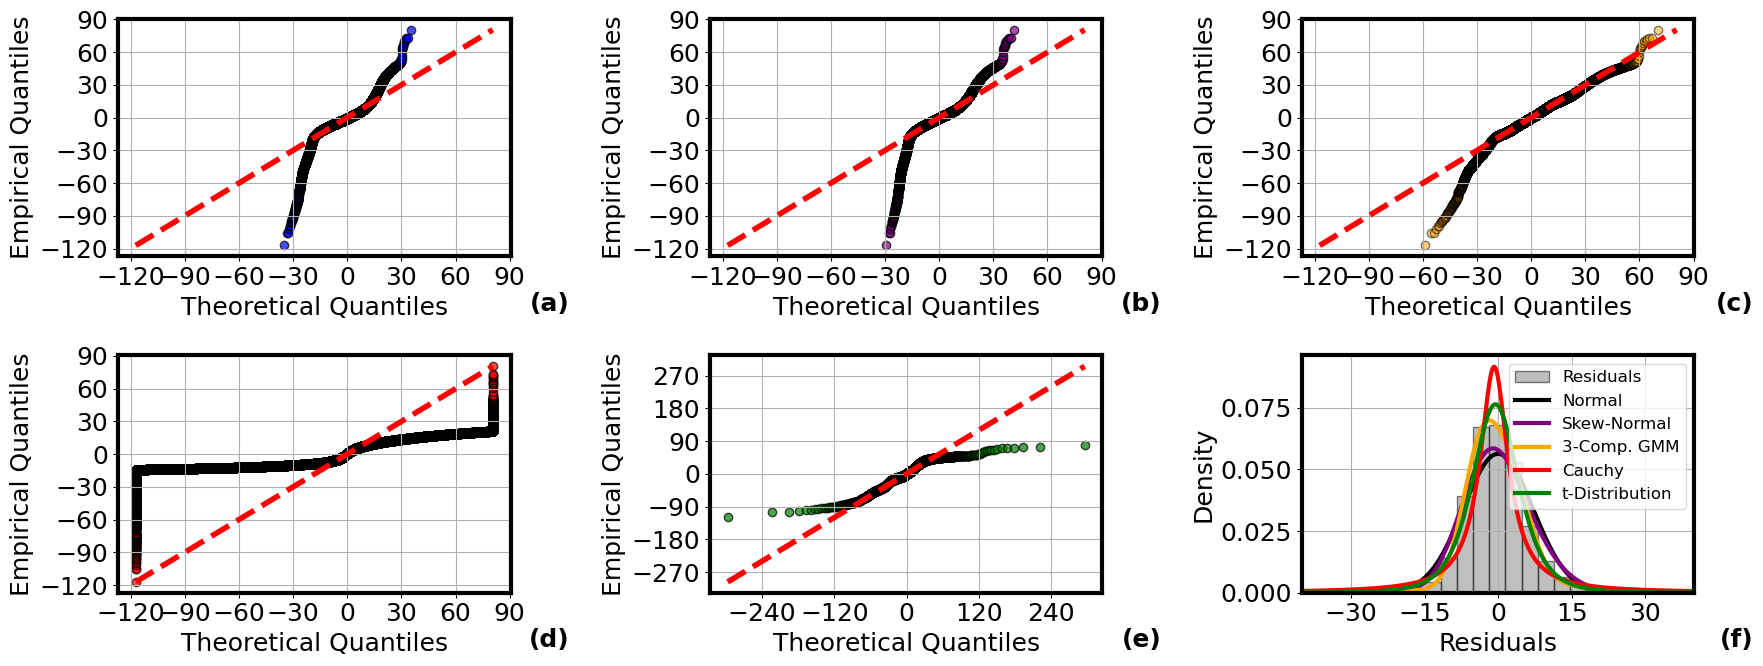

In [15]:
# === Plot Diagnostic Subplots in a 2x3 Grid ===
plt.rcParams.update({
    'font.size': 18,
    'axes.titlesize': 20,
    'axes.labelsize': 18,
    'legend.fontsize': 15
})

fig, axes = plt.subplots(2, 3, figsize=(18, 7))  # 2 rows, 3 columns
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# Define subplot labels for the six subplots
subplot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Function to create manual Q-Q plots
def manual_qq_plot(distribution, dist_name, sorted_residuals, probabilities, ax, color='blue'):
    """
    Create a manual Q-Q plot.
    """
    theoretical_quantiles = distribution.ppf(probabilities)
    ax.scatter(theoretical_quantiles, sorted_residuals, edgecolors='k', facecolor=color, alpha=0.7)
    min_val = min(theoretical_quantiles.min(), sorted_residuals.min())
    max_val = max(theoretical_quantiles.max(), sorted_residuals.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
    #ax.set_title(f'{dist_name} Distribution')
    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Empirical Quantiles')
    ax.grid(True)

# 1. Q-Q Plot (Normal Distribution)
manual_qq_plot(normal_dist, 'Normal', sorted_residuals, probabilities, axes[0], color='blue')
axes[0].text(1.15, -0.15, subplot_labels[0], transform=axes[0].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 2. Q-Q Plot (Skew-Normal Distribution)
manual_qq_plot(skew_dist, 'Skew-Normal', sorted_residuals, probabilities, axes[1], color='purple')
axes[1].text(1.15, -0.15, subplot_labels[1], transform=axes[1].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 3. Q-Q Plot (Gaussian Mixture Model)
x_grid = np.linspace(residuals.min(), residuals.max(), 200000)
cdf_grid = gmm_cdf(x_grid, best_gmm)  # Using best_gmm here
unique_cdf, unique_indices = np.unique(cdf_grid, return_index=True)
unique_x = x_grid[unique_indices]
ppf_func = interp1d(unique_cdf, unique_x, bounds_error=False, fill_value=(x_grid[0], x_grid[-1]))
theoretical_gmm_quantiles = ppf_func(probabilities)

axes[2].scatter(theoretical_gmm_quantiles, sorted_residuals, edgecolors='k', facecolor='orange', alpha=0.5)
min_val = min(theoretical_gmm_quantiles.min(), sorted_residuals.min())
max_val = max(theoretical_gmm_quantiles.max(), sorted_residuals.max())
axes[2].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=4)
#axes[2].set_title('GMM Distribution')
axes[2].set_xlabel('Theoretical Quantiles')
axes[2].set_ylabel('Empirical Quantiles')
axes[2].grid(True)
axes[2].text(1.15, -0.15, subplot_labels[2], transform=axes[2].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 4. Q-Q Plot (Cauchy Distribution)
lower_bound = residuals.min()
upper_bound = residuals.max()
theoretical_quantiles = cauchy_dist.ppf(probabilities)
theoretical_quantiles_clipped = np.clip(theoretical_quantiles, lower_bound, upper_bound)

axes[3].scatter(theoretical_quantiles_clipped, sorted_residuals, edgecolors='k', facecolor='red', alpha=0.7)
axes[3].plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'r--', linewidth=4)
#axes[3].set_title('Cauchy Distribution')
axes[3].set_xlabel('Theoretical Quantiles')
axes[3].set_ylabel('Empirical Quantiles')
axes[3].grid(True)
axes[3].text(1.15, -0.15, subplot_labels[3], transform=axes[3].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 5. Q-Q Plot (t-Distribution)
manual_qq_plot(t_dist, 't-', sorted_residuals, probabilities, axes[4], color='green')
axes[4].text(1.15, -0.15, subplot_labels[4], transform=axes[4].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# 6. Residuals Histogram with Fitted Densities
axes[5].hist(residuals, bins=60, density=True, alpha=0.5, color='grey', edgecolor='black', label='Residuals')
x_vals = np.linspace(residuals.min(), residuals.max(), 1000)
axes[5].plot(x_vals, normal_dist.pdf(x_vals), label='Normal', color='black', linewidth=3)
axes[5].plot(x_vals, skew_dist.pdf(x_vals), label='Skew-Normal', color='purple', linewidth=3)
# Using best_gmm to compute density
gmm_density = np.exp(best_gmm.score_samples(x_vals.reshape(-1, 1)))
axes[5].plot(x_vals, gmm_density, label=f'{best_gmm.n_components}-Comp. GMM', color='orange', linewidth=3)
axes[5].plot(x_vals, cauchy_dist.pdf(x_vals), label='Cauchy', color='red', linewidth=3)
axes[5].plot(x_vals, t_dist.pdf(x_vals), label='t-Distribution', color='green', linewidth=3)
#axes[5].set_title('Residuals Distributions')
axes[5].set_xlabel('Residuals')
axes[5].set_ylabel('Density')
axes[5].legend(fontsize=12)
axes[5].grid(True)
axes[5].set_xlim(-40, 40)
axes[5].text(1.15, -0.15, subplot_labels[5], transform=axes[5].transAxes,
             ha='right', va='top', fontweight='bold', fontsize=18)

# ----- Tick Interval Adjustments  -----
# For subplots a-d (axes[0] to axes[3]), 30
for i in range(0, 4):
    axes[i].xaxis.set_major_locator(MultipleLocator(30))
    axes[i].yaxis.set_major_locator(MultipleLocator(30))

# For subplot e (axes[4]), 60
axes[4].xaxis.set_major_locator(MultipleLocator(120))
axes[4].yaxis.set_major_locator(MultipleLocator(90))

# For histogram subplot f (axes[5]), 15
axes[5].xaxis.set_major_locator(MultipleLocator(15))
# ----- End of Tick Interval Adjustments -----

# Adjust tick font size for all subplots
for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=18)

# Set all subplot border widths (spines) to 3 
for ax in axes:
    for spine in ax.spines.values():
        spine.set_linewidth(3)

# Adjust layout, save figure, and display
plt.tight_layout()
#plt.savefig('../Extended Parametric Regression Files+Plots/qq_residual_plots.png', dpi=1000)
plt.show()